# Titanic Data Investigation

## Background information
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

### Data dictionary
#### Variable
* survival: Survival, 0 = No, 1 = Yes
* pclass: Ticket class, 1 = 1st, 2 = 2nd, 3 = 3rd
* sex: Sex
* age: Age in years
* sibsp: # of siblings / spouses aboard the Titanic
* parch: # of parents / children aboard the Titanic
* ticket: Ticket number
* fare: Passenger fare
* cabin: Cabin number
* embarked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

#### Variable Notes

**pclass:** A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower

**age:** Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5


**sibsp:** The dataset defines family relations in this way...
* Sibling = brother, sister, stepbrother, stepsister
* Spouse = husband, wife (mistresses and fiancés were ignored)

**parch:** The dataset defines family relations in this way...
* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson
* Some children travelled only with a nanny, therefore parch=0 for them.

## Questions to be asked
1. Which of the statistics of a passenger is more likely to affect their survival? Age, gender (children, women and men) or socioeconomic status (corresponding to passenger class)?
2. Did number of family members aboard with a passenger affect the survivability?
3. Did embarked port affect the possibility of survival?

## Data wrangling

In [1]:
# import all necessary packages and functions
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read files
df = pd.read_csv('titanic-data.csv')
df.tail(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [2]:
######################
# define data filter #
######################
def filter_data(data, conditions):
    for condition in conditions:
        field, operator, value = condition.split(' ')
        # fixes data type
        try:
            value = float(value)
        except:
            value = value.strip('\'\"')
        # matches data
        if operator == '>':
            match = data[field] > value
        elif operator == '>=':
            match = data[field] >= value
        elif operator == '<':
            match = data[field] < value
        elif operator == '<=':
            match = data[field] <= value
        elif operator == '==':
            match = data[field] == value
        elif operator == '!=':
            match = data[field] != value
        # outcomes filtered data
        data = data[match].reset_index(drop = True)
    return data
# example
filter_data(df, ['Sex == female', 'Pclass == 1', 'Survived == 0'])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,178,0,1,"Isham, Miss. Ann Elizabeth",female,50.0,0,0,PC 17595,28.7125,C49,C
1,298,0,1,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,C22 C26,S
2,499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0,1,2,113781,151.5500,C22 C26,S


### Missing data

In [3]:
########################
# inspect missing data #
########################
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### report missing data
* 177 'Age' values are missing
* 687 'Cabin' values are missing
* 2 'Embarked' values are missing

#### solutions
* For missing 'Age' values, we will replace NaN with average age of passengers with same 'Title' (e.g. Master, Mrs etc).
* For 'Cabin', too many missing values, we'll ignore them for now.
* For 'Embarked', there are only 2 missing values, we are going to do more investigation.

In [4]:
######################
# set 'Title' column #
######################
# extract title from name
def extract_title(name):
    last_name, first_name = name.split(', ')
    f = first_name.split('. ')
    if len(f) == 1:
        title = ''
    else:
        title = f[0]
    return title
# create 'Title' column
title_col = df['Name'].apply(lambda x: pd.Series(extract_title(x))).rename(columns={0: 'Title'})
# have a look of each unique title for all passengers
title_col.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [5]:
# set a temp value to annotate if there is a missing value for Age
is_missing_age_col = pd.DataFrame({'MissingAge': pd.isnull(df.Age)})
df_temp = pd.concat([df, is_missing_age_col, title_col], axis=1)

In [6]:
# have a look of each unique title for passengers with missing value for Age
df_temp[df_temp['MissingAge'] == True].Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Dr'], dtype=object)

In [7]:
######################################
# deal with missing value for 'Age'  #
######################################
# calculate each average age of passengers with above titles
age_mean_mr = df_temp[df_temp['Title'] == 'Mr']['Age'].mean()
age_mean_mrs = df_temp[df_temp['Title'] == 'Mrs']['Age'].mean()
age_mean_miss = df_temp[df_temp['Title'] == 'Miss']['Age'].mean()
age_mean_master = df_temp[df_temp['Title'] == 'Master']['Age'].mean()
age_mean_dr = df_temp[df_temp['Title'] == 'Dr']['Age'].mean()

# assign value
def set_missing_age(data):
    for i, row in data.iterrows():
        if row['MissingAge'] == True:
            age = 0
            if row['Title'] == 'Mr':
                age = age_mean_mr
            elif row['Title'] == 'Mrs':
                age = age_mean_mrs
            elif row['Title'] == 'Miss':
                age = age_mean_miss
            elif row['Title'] == 'Master':
                age = age_mean_master
            elif row['Title'] == 'Dr':
                age = age_mean_dr
            data.ix[i,'Age'] = age
    return data
df_full_age = set_missing_age(df_temp)

In [8]:
##########################################
# deal with missing value for 'Embarked' #
##########################################
# view the records with missing value for 'Embarked'
df_full_age[df_full_age['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,MissingAge,Title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,False,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,False,Mrs


In [9]:
# assign 'S' to the missing values
# according to wikipedia the two passengers was actually embarked at Southampton
df_full_age['Embarked'].fillna('S', inplace = True)

In [10]:
####################
# check the result #
####################
df_full_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
MissingAge     891 non-null bool
Title          891 non-null object
dtypes: bool(1), float64(2), int64(5), object(6)
memory usage: 91.4+ KB


Now as we can see, except 'Cabin', there are no missing values in the data.

### Duplicated data

In [11]:
############################
# inspects duplicated data #
############################
duplicate_id = df_full_age['PassengerId'].duplicated().sum()
duplicate_name = df_full_age['Name'].duplicated().sum()
if duplicate_id == 0 & duplicate_name == 0:
    print 'There is no duplicate name or ID.'
elif duplicate_id == 0:
    print 'There are {} duplicate Passaenger Names.'.format(duplicate_id)
else:
    print 'There are {} duplicate Passaenger IDs.'.format(duplicate_name)

There is no duplicate name or ID.


According to current inspection, we can assume that there are no duplicate data.

### More data cleaning

In [12]:
#####################################
# set columns: Family', 'Embarked'  #
#####################################
# create 'Family' column to combine sibsp with parch (# of family members aboard the Titanic)
family_col = pd.DataFrame(df_full_age['SibSp'] + df_full_age['Parch'], columns = ['Family'])
# replace embarked port values with full port name (Cherbourg, Queenstown and Southampton)
embarked_col = df_full_age['Embarked'].replace(['C', 'Q', 'S'], ['Cherbourg', 'Queenstown', 'Southampton'])

In [13]:
#######################
# set 'Gender' column #
#######################
# determine whether the passenger is a child
def is_child(age):
    if age >= 16:
        x = 0
    else:
        x = 2
    return x
# assign 2 to every child; 0, 1 to female and male
child = df_full_age['Age'].apply(lambda x: pd.Series(is_child(x))).rename(columns={0: 'Gender'})
sex = pd.DataFrame({'Gender': df_full_age['Sex'].replace(['female', 'male'], [0, 1])})
# create 'Gender' column (Child, Woman and Man)
gender_col = (child + sex).replace([0, 1, 2, 3], ['Woman', 'Man', 'Child', 'Child'])
gender_col.Gender.unique()

array(['Man', 'Woman', 'Child'], dtype=object)

In [14]:
########################
# set 'AgeRange column #
########################
# set age range
def set_range(age):
    if age <= 10.0:
        x = 10
    elif age <= 20.0:
        x = 20
    elif age <= 30.0:
        x = 30
    elif age <= 40.0:
        x = 40
    elif age <= 50.0:
        x = 50
    elif age <= 60.0:
        x = 60
    elif age <= 70.0:
        x = 70
    elif age <= 80.0:
        x = 80
    return x
# assign values
age_range_col = df_full_age['Age'].apply(lambda x: pd.Series(set_range(x))).rename(columns={0: 'AgeRange'})
age_range_col.AgeRange.unique()

array([30, 40, 60, 10, 20, 70, 50, 80])

In [15]:
##########################
# Generate the dataframe #
##########################
# drop unnessisary columns
df_drop = df_full_age.drop(['MissingAge','Name','Sex','Ticket','Cabin','Embarked','SibSp','Parch','Fare'], axis = 1)
# concats data with new columns
df_titanic = pd.concat([df_drop, gender_col, age_range_col, family_col, embarked_col], axis = 1)
df_titanic.head(3)

,PassengerId,Survived,Pclass,Age,Title,Gender,AgeRange,Family,Embarked
0,1,0,3,22.0,Mr,Man,30,1,Southampton
1,2,1,1,38.0,Mrs,Woman,40,1,Cherbourg
2,3,1,3,26.0,Miss,Woman,30,0,Southampton


This is the data our exploration will based on

## Explore data

With the data prepared, now we can start to explore.

### In general

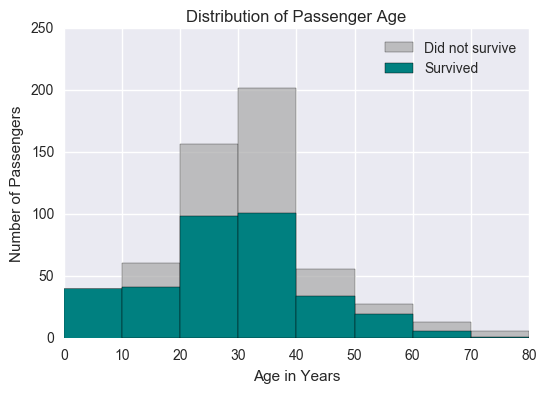

In [16]:
# set global plot parameters
color_sur = 'teal'
color_vic = 'darkgrey'
color_class1 = 'goldenrod'
color_class2 = 'silver'
color_class3 = 'white'
color_child = 'lightseagreen'
color_woman = 'coral'
color_man = 'darkgrey'
lable_sur = 'Survived'
lable_vic = 'Did not survive'

##########################################
# visulizes survival statistics with age #
##########################################
# sets age graph parameters
age_min = df_titanic['Age'].min()
age_max = df_titanic['Age'].max()
age_bins = np.arange(0, age_max + 10, 10)
# survivors vs. victims
victims = df_titanic[df_titanic['Survived'] == 0]['Age'].reset_index(drop = True)
survivors = df_titanic[df_titanic['Survived'] == 1]['Age'].reset_index(drop = True)
# plots
plt.hist(victims, bins = age_bins, label = lable_vic, color = color_vic, alpha = 0.7)
plt.hist(survivors, bins = age_bins, label = lable_sur, color = color_sur)
plt.xlim(0, 80)
plt.legend(framealpha = 0.8)
plt.xlabel('Age in Years')
plt.ylabel('Number of Passengers')
plt.title('Distribution of Passenger Age')
plt.show()

From this plot we can see that most passengers were in middle-aged, and age from 0 to 10 years passenger seem to have a higher survival rate. We'll go deeper later.

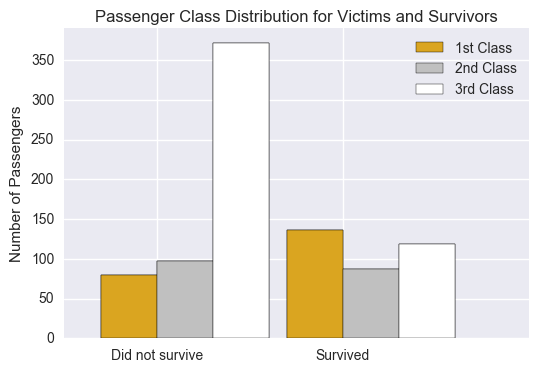

In [17]:
######################################################
# visulizes survival statistics with Passenger Class #
######################################################
# set data for the plot
pclass_count = df_titanic.groupby(['Pclass','Survived']).count()['PassengerId']
# visulize survival rate with family members and passenger class
cate = [lable_vic, lable_sur]
x = np.array([1, 2])
binwidth = 0.3
for i, cate_value in enumerate(cate):
    st_plt = plt.bar(x - binwidth, pclass_count[1], width = binwidth, color = color_class1)
    nd_plt = plt.bar(x, pclass_count[2], width = binwidth, color = color_class2)
    rd_plt = plt.bar(x + binwidth, pclass_count[3], width = binwidth, color = color_class3)
plt.xticks(x, cate)
plt.legend(['1st Class','2nd Class','3rd Class'])
plt.ylim(0, 390)
plt.ylabel('Number of Passengers')
plt.title('Passenger Class Distribution for Victims and Survivors')
plt.show()

As can be seen from the left charts (did not survive), the number of third-class passengers is the highest. But when we look at the charts on the right (survived), situation changes, the first-class stands out. Only the number of survivors in the first-class exceeded the victims. It means that the first-class passengers may have a higher survival rate.

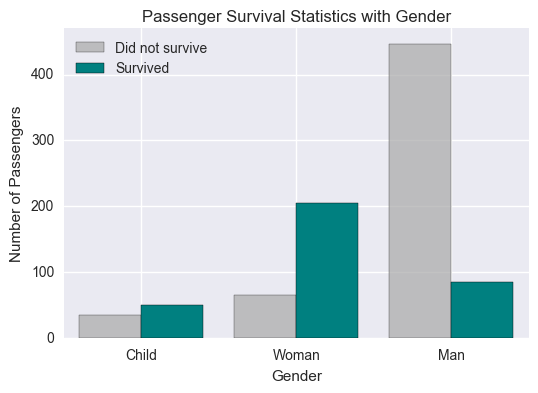

In [18]:
#############################################
# visulizes survival statistics with gender #
#############################################
cate = ['Child', 'Woman', 'Man']          
# sets data to sum passenger numbers grouped by gender
cate_df = pd.DataFrame(index = np.arange(len(cate)), columns=('Gender','survivors','victims'))
for i, cate_value in enumerate(cate):
    cate_df.loc[i] = [cate_value, len(df_titanic[(df_titanic['Survived']==1) & (df_titanic['Gender']==cate_value)]),\
                      len(df_titanic[(df_titanic['Survived']==0) & (df_titanic['Gender']== cate_value)])]     
# plots survivors vs. victims
binwidth = 0.4
for i, cate_value in enumerate(cate):
    victims_plt = plt.bar(i - binwidth, cate_df.loc[i]['victims'], width = binwidth, color = color_vic, alpha = 0.7)
    survivors_plt = plt.bar(i, cate_df.loc[i]['survivors'], width = binwidth, color = color_sur)
plt.xticks(np.arange(len(cate_df)), cate)
plt.legend((victims_plt[0], survivors_plt[0]),(lable_vic, lable_sur), loc = 2, framealpha = 0.8)
plt.ylim(0, 470)
plt.xlabel('Gender')
plt.ylabel('Number of Passengers')
plt.title('Passenger Survival Statistics with Gender')
plt.show()

Obviously, more women survived. And the survival rate of woman passengers was also higher. It seems that "Gender" will be an meaningful factor in the survival, we must need further investigation.

### Survival Rate
Now it's time to investigate data from the perspective of survival rate.

In [19]:
####################################
# get survival rate for given keys #
####################################
def get_sur_rate(data, key, single_col = False):
    c = (data.groupby([key]).sum() / data.groupby([key]).count() * 100)['Survived'].reset_index()
    c.columns = [key, 'Survival Rate']
    if single_col == True:
        sur = c['Survival Rate']
        sur.index = c[key]
    else:
        sur = c
    return sur
# example
get_sur_rate(df_titanic, 'Gender', single_col = True)

Gender
Child    58.620690
Man      16.135084
Woman    75.645756
Name: Survival Rate, dtype: float64

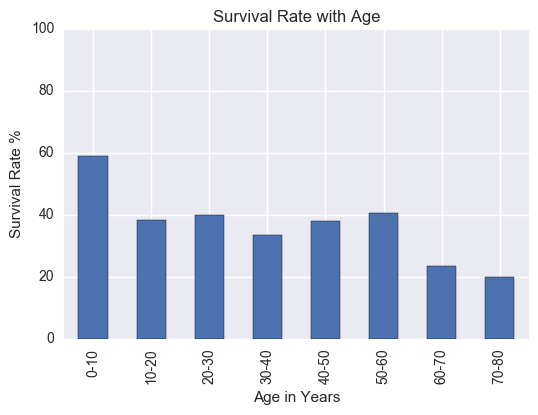

0-10     58.823529
10-20    38.260870
20-30    39.849624
30-40    33.333333
40-50    37.931034
50-60    40.476190
60-70    23.529412
70-80    20.000000
Name: Survival Rate, dtype: float64

In [20]:
# visulize survival rate with age range
age_range_sur = get_sur_rate(df_titanic, 'AgeRange', single_col=True)
age_range_sur.index = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80']
age_range_sur.plot.bar(legend = False)
plt.xlabel('Age in Years')
plt.ylabel('Survival Rate %')
plt.title('Survival Rate with Age')
plt.ylim(0, 100)
plt.show()
age_range_sur

As expected, the survival rate of 0 to 10 years old passengers was the highest, reaching 58.82%. But for other age ranges, the difference in survival rate does not seem too obvious.

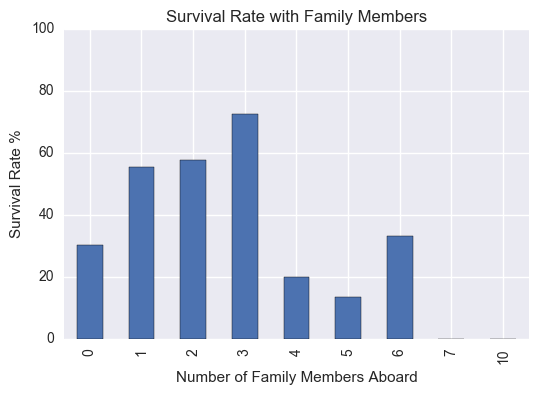

In [21]:
# visulize survival rate with number of family members aboard
family_sur = get_sur_rate(df_titanic, 'Family', single_col=True)
family_sur.plot.bar(legend = False)
plt.xlabel('Number of Family Members Aboard')
plt.ylabel('Survival Rate %')
plt.title('Survival Rate with Family Members')
plt.ylim(0, 100)
plt.show()

Passengers with 3 family members aboard (not include himself) seem to have a higher survival rate. Is this a coincidence? We'll get this back later.

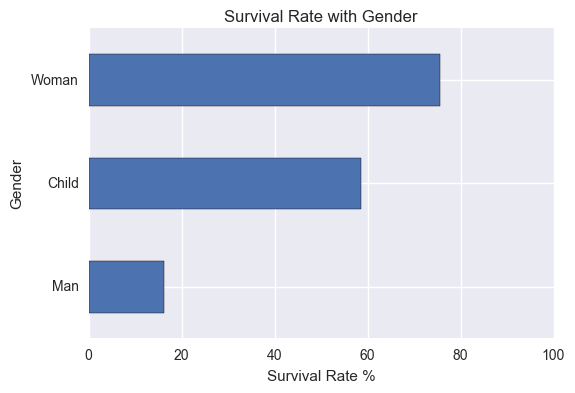

In [22]:
# visulize survival rate with gender category
gender_sur = get_sur_rate(df_titanic, 'Gender', single_col=True)
gender_sur.sort_values().plot.barh(legend = False)
plt.xlabel('Survival Rate %')
plt.title('Survival Rate with Gender')
plt.xlim(0, 100)
plt.show()

Once again, the data shows that women in Titanic had higher survival rate than that of men, and even children.

This is in line with the famous "women and children first" principle which might be a reason to result in the death of thousand of passengers and crew.

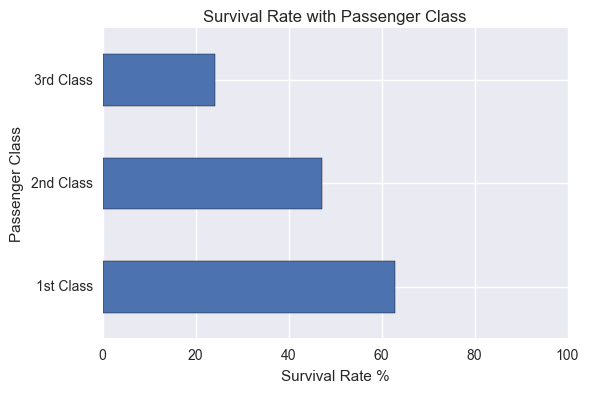

1st Class    62.962963
2nd Class    47.282609
3rd Class    24.236253
Name: Survival Rate, dtype: float64

In [23]:
# visulize survival rate with passenger class category
pclass_sur = get_sur_rate(df_titanic, 'Pclass', single_col=True)
pclass_sur.index = ['1st Class','2nd Class','3rd Class']
pclass_sur.plot.barh(legend = False)
plt.ylabel('Passenger Class')
plt.xlabel('Survival Rate %')
plt.title('Survival Rate with Passenger Class')
plt.xlim(0, 100)
plt.show()
pclass_sur

First-class passengers in Titanic had the highest survival rate, followed by second-class, and finally third-class.

Actually it is consistent with the story we’ve heard about. 
* First-class passengers got better help from the crew. 
* First-class cabins were closer to lifeboats. 
* A lot of third-class passengers were non-English speaking meant it was hard for them to get useful information to escape.
* etc

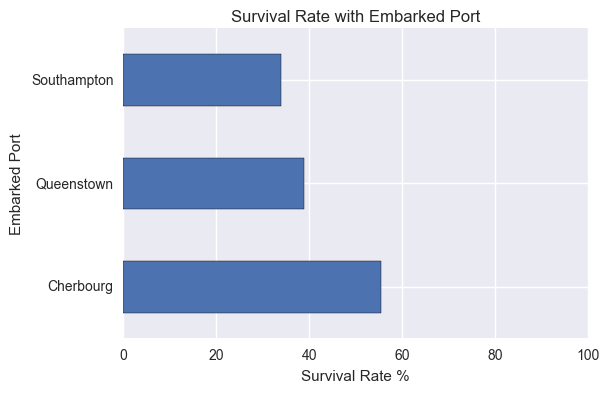

In [24]:
# visulize survival rate with embarked port
embarked_sur = get_sur_rate(df_titanic, 'Embarked', single_col=True)
embarked_sur.plot.barh(legend = False)
plt.ylabel('Embarked Port')
plt.xlabel('Survival Rate %')
plt.title('Survival Rate with Embarked Port')
plt.xlim(0, 100)
plt.show()

This one is very interesting. 34%, 39% and 55%, why was the survival rate of passengers from Cherbourg so much higher than the other two (at least 15%)? Would it be a key factor? We'll discuss it later.

#### Category combination
We'll show survival statistics by combining several valid categories

In [25]:
# combine categories of 'Pclass', 'Gender', 'Family', 'AgeRange', 'Embarked' and get survival rate
g = df_titanic.groupby(['Pclass', 'Gender', 'Family', 'AgeRange', 'Embarked'])
cate_sur_rate = (g.sum() / g.count() * 100)['Survived'].reset_index()
cate_sur_rate.rename(columns={'Survived': 'Survival Rate'}, inplace = True)
cate_sur_rate.head(3)

,Pclass,Gender,Family,AgeRange,Embarked,Survival Rate
0,1,Child,1,20,Southampton,100.0
1,1,Child,2,10,Southampton,100.0
2,1,Child,3,10,Southampton,50.0


In [26]:
###############
# correlation #
###############
# reset categorical variables ('Gender' and 'Embarked') into numerical
# order: the same order with the survial rate
cate_sur_rate['Gender'].replace('Man', 1, inplace=True)
cate_sur_rate['Gender'].replace('Child', 2, inplace=True)
cate_sur_rate['Gender'].replace('Woman', 3, inplace=True)
cate_sur_rate['Embarked'].replace('Southampton', 1, inplace=True)
cate_sur_rate['Embarked'].replace('Queenstown', 2, inplace=True)
cate_sur_rate['Embarked'].replace('Cherbourg', 3, inplace=True)
# show correlation of these categories
cate_sur_rate.corr()

,Pclass,Gender,Family,AgeRange,Embarked,Survival Rate
Pclass,1.000000,0.021802,0.200587,-0.261059,-0.081552,-0.369175
Gender,0.021802,1.000000,0.098354,-0.146258,-0.025453,0.572911
Family,0.200587,0.098354,1.000000,-0.265038,-0.224943,-0.157876
AgeRange,-0.261059,-0.146258,-0.265038,1.000000,-0.057935,-0.158777
Embarked,-0.081552,-0.025453,-0.224943,-0.057935,1.000000,0.073546
Survival Rate,-0.369175,0.572911,-0.157876,-0.158777,0.073546,1.000000


Either the last row or the last column can tells us the correlation between each category and the survival rate. This is, from high to low: Gender (0.57), Pclass (-0.37), AgeRange (-0.159), Family (-0.158), Embarked (0.07). 

Gender has the strongest correlation with survival rate. It's obvious that survival rate of women, children and of men diminishes.

Pclass obtains a negative correlation with survival rate. This means from 1st class, 2nd to the 3rd class, the survival rate decreases while the class number increases. That's what we talked about. 

AgeRange and Family share a weaker correlation with the survival rate. And also negative.

AgeRange, in addition to age range 0-10, the difference in survival rate among other age ranges is not obvious. 

Family, as our previous explorations show, from 0 to 3 (family members), the survival rate increases, after 3, the situation is more complex.

Embarked has the weakest correlation with the survival rate. Although passengers from Cherbourg did have a higher survival rate than others, this effect may not be straightforward.

#### About family members

In [27]:
# explore data of passengers who have 3 family members aboard
df_f3 = filter_data(df_titanic, ['Family == 3'])
n_total = len(df_f3)
n_w = (df_f3.Gender == 'Woman').sum()
n_c = (df_f3.Gender == 'Child').sum()
n_m = (df_f3.Gender == 'Man').sum()
n_1st = (df_f3.Pclass == 1).sum()
n_2nd = (df_f3.Pclass == 2).sum()
n_3rd = (df_f3.Pclass == 3).sum()
print '{} out of {} passengers who have 3 family members aboard are women ({}%),\
{} are children ({}%), only {} are men ({}%).'.format(n_w, n_total, n_w*100/n_total, n_c, n_c*100/n_total,\
                                                      n_m, n_m*100/n_total)
print 'Among these, {} are first-class passengers ({}%), {} are second class ({}%),\
and {} are third class ({}%).'.format(n_1st, n_1st*100/n_total, n_2nd, n_2nd*100/n_total, n_3rd, n_3rd*100/n_total)

11 out of 29 passengers who have 3 family members aboard are women (37%),12 are children (41%), only 6 are men (20%).
Among these, 7 are first-class passengers (24%), 13 are second class (44%),and 9 are third class (31%).


In [28]:
# show the passenger data of 5 family members as a comparison
df_f5 = filter_data(df_titanic, ['Family == 5'])
n_total = len(df_f5)
n_w = (df_f5.Gender == 'Woman').sum()
n_c = (df_f5.Gender == 'Child').sum()
n_m = (df_f5.Gender == 'Man').sum()
n_1st = (df_f5.Pclass == 1).sum()
n_2nd = (df_f5.Pclass == 2).sum()
n_3rd = (df_f5.Pclass == 3).sum()
print '{} out of {} passengers who have 3 family members aboard are women ({}%),\
{} are children ({}%), only {} are men ({}%).'.format(n_w, n_total, n_w*100/n_total, n_c, n_c*100/n_total,\
                                                      n_m, n_m*100/n_total)
print 'Among these, {} are first-class passengers ({}%), {} are second class ({}%),\
and {} are third class ({}%).'.format(n_1st, n_1st*100/n_total, n_2nd, n_2nd*100/n_total, n_3rd, n_3rd*100/n_total)

6 out of 22 passengers who have 3 family members aboard are women (27%),12 are children (54%), only 4 are men (18%).
Among these, 4 are first-class passengers (18%), 1 are second class (4%),and 17 are third class (77%).


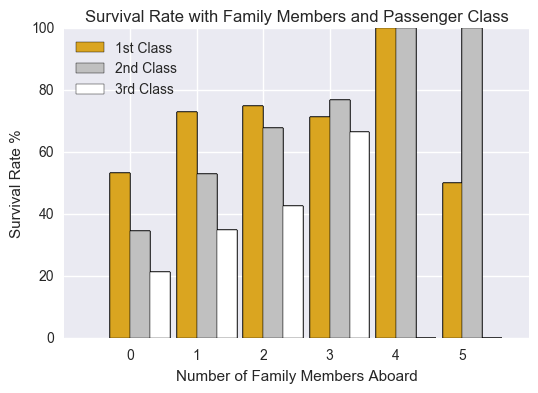

In [29]:
# set data for the plot
df_f0to5 = filter_data(df_titanic, ['Family < 6'])
pclass_family = df_f0to5.groupby(['Pclass','Family'])
pclass_family_sur_rate = (pclass_family.sum() / pclass_family.count() * 100)['Survived']
# visulize survival rate with family members and passenger class
cate = [0, 1, 2, 3, 4, 5]
x = np.array([1, 2, 3, 4, 5, 6])
binwidth = 0.3
for i, cate_value in enumerate(cate):
    st_plt = plt.bar(x - binwidth, pclass_family_sur_rate[1], width = binwidth, color = color_class1)
    nd_plt = plt.bar(x, pclass_family_sur_rate[2], width = binwidth, color = color_class2)
    rd_plt = plt.bar(x + binwidth, pclass_family_sur_rate[3], width = binwidth, color = color_class3)
plt.xticks(x, cate)
plt.legend(['1st Class','2nd Class','3rd Class'], loc = 2)
plt.ylim(0, 100)
plt.xlabel('Number of Family Members Aboard')
plt.ylabel('Survival Rate %')
plt.title('Survival Rate with Family Members and Passenger Class')
plt.show()

In this case, 24% of passengers with 3 families were first-class and 44% were second-class, while 77% of passengers with 5 families are third-class. But from the plot, we can see that the third-class passenger with 5 families did have very low survival rate. So maybe the reason is more complex than we thought.

#### About embarked port

In [30]:
# explore data of passengers from Cherbourg
df_cherbourg = filter_data(df_titanic, ['Embarked == Cherbourg'])
n_total = len(df_cherbourg)
n_w = (df_cherbourg.Gender == 'Woman').sum()
n_c = (df_cherbourg.Gender == 'Child').sum()
n_m = (df_cherbourg.Gender == 'Man').sum()
n_1st = (df_cherbourg.Pclass == 1).sum()
n_2nd = (df_cherbourg.Pclass == 2).sum()
n_3rd = (df_cherbourg.Pclass == 3).sum()
print '{} out of {} passengers from Cherbourg are women ({}%), \
{} are children ({}%), {} are men ({}%).'.format(n_w, n_total, n_w*100/n_total, n_c, n_c*100/n_total,\
                                                 n_m, n_m*100/n_total)
print 'Among these, {} are first-class passengers ({}%), {} are second class ({}%),\
# and {} are third class ({}%).'.format(n_1st, n_1st*100/n_total, n_2nd, n_2nd*100/n_total, n_3rd, n_3rd*100/n_total)

60 out of 168 passengers from Cherbourg are women (35%), 20 are children (11%), 88 are men (52%).
Among these, 85 are first-class passengers (50%), 17 are second class (10%),# and 66 are third class (39%).


In [31]:
# show Southampton passenger data as a comparison
df_southampton = filter_data(df_titanic, ['Embarked == Southampton'])
n_total = len(df_southampton)
n_w = (df_southampton.Gender == 'Woman').sum()
n_c = (df_southampton.Gender == 'Child').sum()
n_m = (df_southampton.Gender == 'Man').sum()
n_1st = (df_southampton.Pclass == 1).sum()
n_2nd = (df_southampton.Pclass == 2).sum()
n_3rd = (df_southampton.Pclass == 3).sum()
print '{} out of {} passengers from Cherbourg are women ({}%), \
{} are children ({}%), {} are men ({}%).'.format(n_w, n_total, n_w*100/n_total, n_c, n_c*100/n_total,\
                                                 n_m, n_m*100/n_total)
print 'Among these, {} are first-class passengers ({}%), {} are second class ({}%),\
# and {} are third class ({}%).'.format(n_1st, n_1st*100/n_total, n_2nd, n_2nd*100/n_total, n_3rd, n_3rd*100/n_total)

176 out of 646 passengers from Cherbourg are women (27%), 62 are children (9%), 408 are men (63%).
Among these, 129 are first-class passengers (19%), 164 are second class (25%),# and 353 are third class (54%).


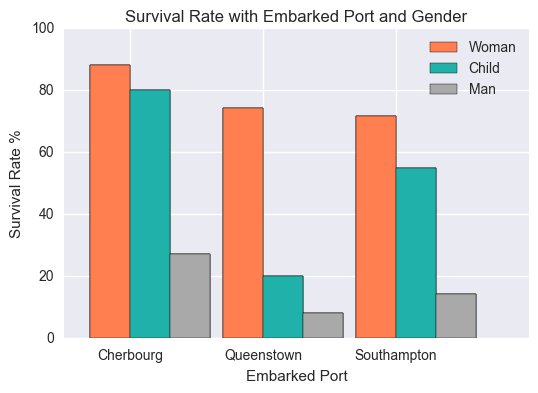

In [32]:
# set data for the plot
gender_embarked = df_titanic.groupby(['Gender','Embarked'])
gender_embarked_sur_rate = (gender_embarked.sum() / gender_embarked.count() * 100)['Survived']
# visulize survival rate with embarked port and gender
cate = ['Cherbourg', 'Queenstown', 'Southampton']
x = np.array([1, 2, 3])
binwidth = 0.3
for i, cate_value in enumerate(cate):
    woman_plt = plt.bar(x - binwidth, gender_embarked_sur_rate.Woman, width = binwidth, color = color_woman)
    child_plt = plt.bar(x, gender_embarked_sur_rate.Child, width = binwidth, color = color_child)
    man_plt = plt.bar(x + binwidth, gender_embarked_sur_rate.Man, width = binwidth, color = color_man)
plt.xticks(x, cate)
plt.legend(['Woman','Child','Man'])
plt.ylim(0, 100)
plt.xlabel('Embarked Port')
plt.ylabel('Survival Rate %')
plt.title('Survival Rate with Embarked Port and Gender')
plt.show()

In this case, 35% of passengers from Cherbourg were women and 11% were children, while 27% of passengers from Southampton were women and 9% were children. The plot shows that women and children from Cherbourg had a higher survival rate than Queenstown and Southampton. 50% first-class passengers might contribute to this ratio. But overall, we can't say that embarked port affected the possibility of survival.

## Conclusion

First of all, from our analysis, although tentative, we could make a guess that being a woman or a child rather than man, with upper social-economic standing (first or second class), may give better chance to survive in Titanic disaster.

For the questions we raised above:

#### Q1. Which of the statistics of a passenger is more likely to affect their survival? Age, gender (children, women and men) or socioeconomic status (corresponding to passenger class)?

From above analysis, we speculate that the correlation between gender and survival is stronger, followed by passenger class. The correlation between age and survival is much weaker.

#### Q2. Did number of family members aboard with a passenger affect the survivability?

Passenger accompanied by 3 family members seems to have higher survival rate, though 24% first-class passengers and 44% second class passengers did contribute to this ratio. And for third-class passengers, more than 3 family members accompanied by might get a very low survival rate.

#### Q.3 Did embarked port affect the possibility of survival?

Overall, we can't say that embarked port affected the possibility of survival.

### limitation

However, there are a few limitations of the dataset.

First, the sample collected here may be biased. We don't know how the sample was chosen from the actual population of passengers that were on the Titanic. There could have been some sort of intentional or unintentional bias in how the sample was selected.

And, the data does not provide enough information about family members. For example, there is a passenger with "SibSp" attribute of 4, but 2 of them might be missing from our sample. But normally they shared same ticket record, one "Fare", same "Cabin". It makes it so difficult for us to explore more deeply.

All of these limitations come from differences between the sample and the population.

### Predict

I'm so curious, if I boarded the Titanic, could I survive? To answer this question, we'll need the following inormation.

I am a female adult, with age range 30-40. Normally I travle alone.
Ticket class? Let's have a look at the fare first.

According to "Facts About The RMS Titanic" http://members.tripod.com/~titanic3/facts.html

* First Class (parlor suite) £870 (50,000 USD today) 
* First Class (berth) £30 (1724 USD today) 
* Second Class £12 (690 USD today) 
* Third Class £3 to £8 (172 to 460 USD today)

It looks like second class would be my choice.

So here comes our data:
* PassengerID: 2017
* Pclass: 'Middle'
* Gender: 'Woman'
* AgeRange: 40
* Family: 0

Let's start from here.

In [33]:
test_data = filter_data(df_titanic, ['Pclass == 2', 'Gender == Woman', 'AgeRange == 40', 'Family == 0'])
test_data

,PassengerId,Survived,Pclass,Age,Title,Gender,AgeRange,Family,Embarked
0,124,1,2,32.5,Miss,Woman,40,0,Southampton
1,162,1,2,40.0,Mrs,Woman,40,0,Southampton
2,191,1,2,32.0,Mrs,Woman,40,0,Southampton
3,212,1,2,35.0,Miss,Woman,40,0,Southampton
4,328,1,2,36.0,Mrs,Woman,40,0,Southampton
5,347,1,2,40.0,Miss,Woman,40,0,Southampton
6,358,0,2,38.0,Miss,Woman,40,0,Southampton
7,388,1,2,36.0,Miss,Woman,40,0,Southampton
8,517,1,2,34.0,Mrs,Woman,40,0,Southampton
9,577,1,2,34.0,Miss,Woman,40,0,Southampton


In [34]:
x_bar = test_data['Survived'].mean()
print 'Point estimate (survival rate): {}%'.format(round(x_bar*100, 2))

Point estimate (survival rate): 90.0%


In [35]:
n = len(test_data)
sigma = test_data['Survived'].std(ddof=1)
t_critical = 1.96
lower_bound = x_bar - (t_critical * sigma / np.square(n))
upper_bound = x_bar + (t_critical * sigma / np.square(n))
print 'Interval estimate: 95% CI = ({}%, {}%)'.format(round(lower_bound*100, 2), round(upper_bound*100, 2))

Interval estimate: 95% CI = (89.38%, 90.62%)


Based on point estimation, I may have 90% chance to survived. And according to interval estimation (95% CI), There is a 95% probability that my survival rate is between 89.38% to 90.62%. Not TOO bad, isn't it?

Again, all these estimation are based on the sample. And correlation does not imply causation.

## References

* Encyclopedia Titanica http://www.encyclopedia-titanica.org
* Passengers of the RMS Titanic https://en.wikipedia.org/wiki/Passengers_of_the_RMS_Titanic
* Facts About The RMS Titanic http://members.tripod.com/~titanic3/facts.html
